In [1]:
from tqdm import tqdm

In [2]:
import pandas as pd
from nltk.translate import bleu_score
from numpy.linalg import norm
import numpy as np

df = pd.read_csv("./data/comment_finder/all.csv")

chencherry = bleu_score.SmoothingFunction()

def getBleuScore(test_idx, match_idx):
    ref = df.iloc[[test_idx]].to_records()[0][2]
    hyp = df.iloc[[match_idx]].to_records()[0][2]
    bleu_score_val = bleu_score.sentence_bleu([ref], hyp, smoothing_function=chencherry.method1)
    return bleu_score_val


def find_similiar(data_vector, test_id):

    A = data_vector[test_id]

    max_cosine = 0
    max_sim_id=-1
    for i, B in enumerate(data_vector):
        cosine = np.dot(A,B)/(norm(A)*norm(B))
        if i == test_id:
            continue
        if cosine>max_cosine:
            max_sim_id = i
            max_cosine = cosine
    return max_sim_id, max_cosine

In [3]:
from libs.feature_extraction.vectorizers import BertVectorizer
import numpy as np
from scipy.signal import stft
import tensorflow as tf

bert = BertVectorizer("microsoft/unixcoder-base")
vectors = bert.load_vectors("data/comment_finder/vectors/bert_vectors.npy")

stft_list=[]

for index, vector in tqdm(enumerate(vectors), total=len(vectors)):
    f, t, Zxx_db = stft(vector, fs = 128, nperseg = 128, noverlap = 116, nfft = 128)
    Zxx_db = tf.abs(Zxx_db)
    Zxx_db = Zxx_db[:64,:64]
    stft_list.append(Zxx_db)
    
stft_list = np.concatenate(stft_list)
display(stft_list.shape)
vectors = stft_list.reshape(stft_list.shape[0]//64, 1, 64, 64, 1)
display(vectors.shape)

2023-02-17 08:25:18.633980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 08:25:18.780075: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2023-02-17 08:25:18.780107: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-17 08:25:19.393251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open share

Loading model(microsoft/unixcoder-base)...


  0%|          | 0/150677 [00:00<?, ?it/s]2023-02-17 08:25:28.617308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2023-02-17 08:25:28.617410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2023-02-17 08:25:28.617479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2023-02-17 08:25:28.619369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_load

(9643328, 64)

(150677, 1, 64, 64, 1)

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
import tensorflow as tf

class VGG19DeepConvolutionNetwork:
    __model = None

    def __init__(self):
        self.model()

    def model(self, inputShape=(64, 64, 1)):

        inputLayer = Input(shape=inputShape)

        layerSet = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputLayer)
        layerSet = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(layerSet)
        layerSet = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(layerSet)
        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(layerSet)
        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(layerSet)
        layerSet = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(layerSet)
        layerSet = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(layerSet)
        layerSet = MaxPooling2D(strides=(2,2), padding='same')(layerSet)

        layerSet = Flatten()(layerSet)
        layerSet = Dense(4096, activation='relu')(layerSet)
        layerSet = Dropout(0.5)(layerSet)
        outputLayer = Dense(4096, activation='relu')(layerSet)
        #layerSet = Dropout(0.5)(layerSet)
        #outputLayer = Dense(1000, activation='relu')(layerSet)

        self.__model = Model(inputs=[inputLayer], outputs=[outputLayer])

        self.__model.compile(optimizer='adam', loss='cosine_similarity')
        print(self.__model.summary())

    def getModel(self):
        return self.__model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                             

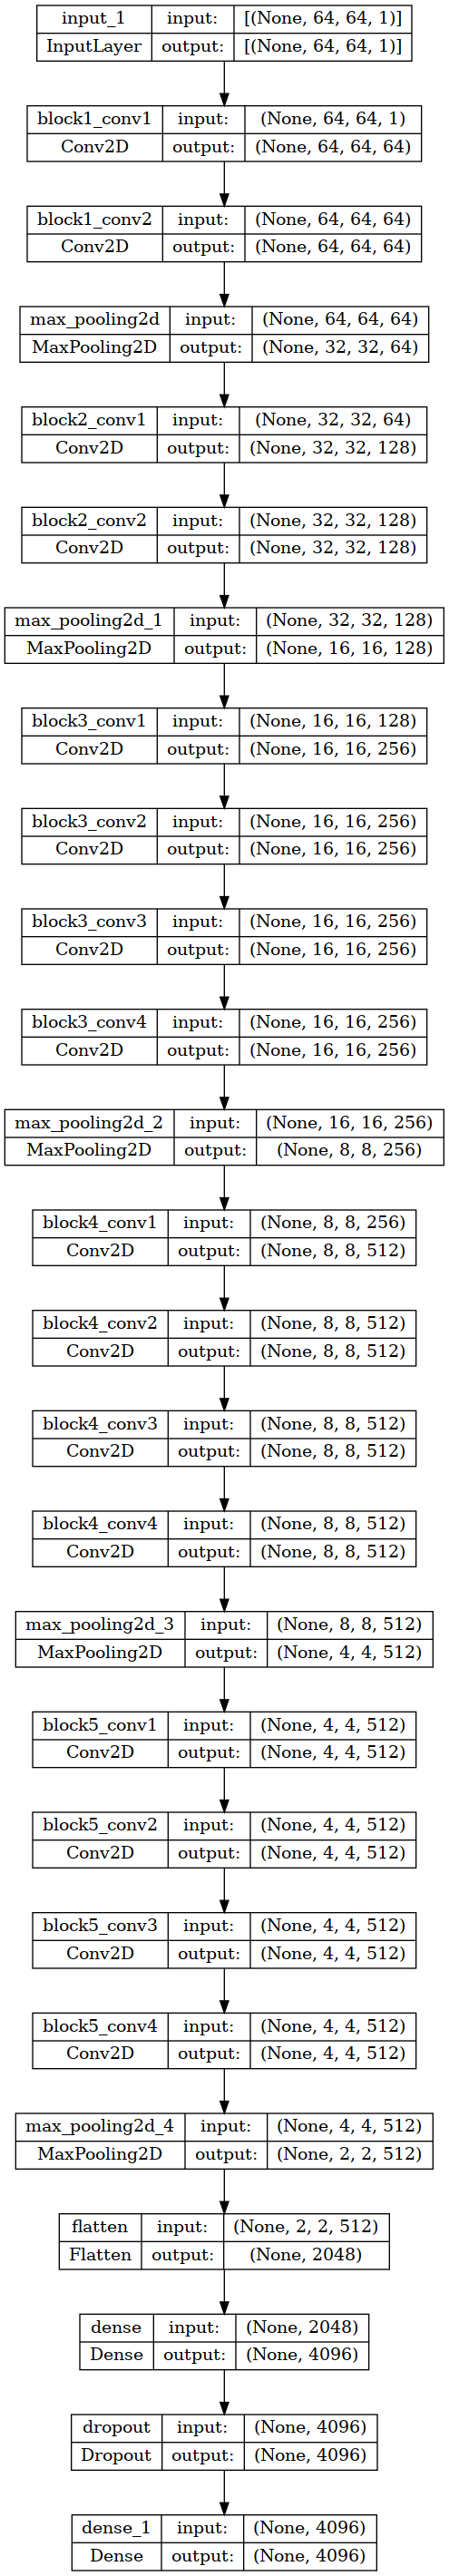

In [6]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image, display

modelWrapper = VGG19DeepConvolutionNetwork()
model = modelWrapper.getModel()
model.save('v5_vgg_64x64.h5')
plot_model(model, to_file='v5_vgg_64x64.png', show_shapes=True, show_layer_names=True)
display(Image("v5_vgg_64x64.png"))

In [7]:
preds_all = np.zeros((len(vectors),4096))
for j in tqdm(range(vectors.shape[0])):
    preds_all[j] = model.predict(vectors[j],verbose = 0)
np.save("v5_preds", preds_all)

100%|██████████| 150677/150677 [3:22:41<00:00, 12.39it/s]  


In [8]:
from annoy import AnnoyIndex

dims = 4096
trees = 10000
file_index_to_file_vector = {}

# build ann index
t = AnnoyIndex(dims, metric='angular')
for i in tqdm(range(preds_all.shape[0])):
    file_vector = preds_all[i]
    file_index_to_file_vector[i] = file_vector
    t.add_item(i, file_vector)
t.build(trees)
t.save("v5.annoy")

100%|██████████| 150677/150677 [00:45<00:00, 3328.53it/s]


True

In [9]:
from annoy import AnnoyIndex

dims = 4096
trees = 10000
file_index_to_file_vector = {}

# build ann index
t = AnnoyIndex(dims, metric='angular')
t.load("v5.annoy")
preds_all = np.load("v5_preds.npy")

In [10]:
test_df = pd.read_csv("./results/bert_cosine_bleu_C1_F5/fold_1.csv")
test_series = test_df.test_idx

sum = 0
toplam = 1000 #len(test_series)
for index, test_idx in tqdm(enumerate(test_series), total=toplam):
    if index > toplam-1:
        break
    nearest_neighbours = t.get_nns_by_vector(preds_all[test_idx], 10)
    max_sim_id = nearest_neighbours[1]
    bleu_score_val = getBleuScore(test_idx,max_sim_id)
    sum = sum + bleu_score_val
    
avg_bleu_score = sum / toplam
display(avg_bleu_score)

100%|██████████| 1000/1000 [02:03<00:00,  8.08it/s]


0.1019362123238813